In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import pickle
from plot import *
from utils import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler, random_split

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.signal import stft
from scipy.fft import fft, fftfreq,rfft, rfftfreq

RANDOM_STATE = 42

In [5]:
################  Parameters  ################

SEPCTURAL_SAMPLES = 13 # 10 in original code
FEATURE_DIM = SEPCTURAL_SAMPLES*6*2
CONV_K = [3,3,3] #[3,4,5]
CONV_C = [32,32,64] # Channels
GRU_H = [120,120] # rnn hidden size
AT = 80
OUT_DIM = 6 # number of activities
WIDE = 20 # window size
CONV_KEEP_PROB = 0.8 # dropout

BATCH_SIZE = 64
EPOCHS = 3000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = './'

# CONV_MERGE_LEN = 8
# CONV_MERGE_LEN2 = 6
# CONV_MERGE_LEN3 = 4
# CONV_NUM2 = 64

# select = 'a'
# metaDict = {'a':[119080, 1193], 'b':[116870, 1413], 'c':[116020, 1477]}
# TRAIN_SIZE = metaDict[select][0]
# EVAL_DATA_SIZE = metaDict[select][1]
# EVAL_ITER_NUM = int(math.ceil(EVAL_DATA_SIZE / BATCH_SIZE))

## 1. Data preprocessing

### 1.1 read data

In [ ]:
# PAMAP Data

In [6]:
data = pd.read_csv('/Users/momo/Documents/dataset/pamap2+physical+activity+monitoring/Protocol/subject101.dat', sep=' ', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.008300,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.006577,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.003014,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,0.003175,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,0.012698,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0


In [7]:
# get the data of the subject and returns df with the relevant information
def prep_data(path, subject):
    data = pd.read_csv(path, sep=' ', header=None)
    data.columns = pd.RangeIndex(1, len(data.columns) + 1) 
    data.drop(3, axis='columns', inplace=True)
    data = data.dropna()
    data = data[[1,2,22,23,24,28,29,30]]
    cols = {1: 'time_step', 2: 'activity_id', 22: 'acc_x', 23: 'acc_y', 24: 'acc_z', 28: 'gyro_x', 29: 'gyro_y', 30: 'gyro_z'}
    data = data.rename(columns=cols)
    # calculating norm
    data['acc_norm'] = np.sqrt(data['acc_x'] ** 2 + data['acc_y'] ** 2 + data['acc_z'] ** 2)
    data['gyro_norm'] = np.sqrt(data['gyro_x'] ** 2 + data['gyro_y'] ** 2 + data['gyro_z'] ** 2)
    data['User'] = f'{subject}'
    print(f'{subject}')
    return data

In [8]:
# Perform preprocess for different subjects
# subjects = ['101', '102', '105', '106', '107', '108']
subjects = ['101']
path = '/Users/momo/Documents/dataset/pamap2+physical+activity+monitoring/Protocol'
data_list = []
for subject in subjects:
    data_list.append(prep_data(path + '/subject' + subject + '.dat', subject))

101


In [9]:
data_list[0].head()

,time_step,activity_id,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,acc_norm,gyro_norm,User
0,8.38,0,0.238080,9.80003,-1.68896,-0.005065,-0.006781,-0.005663,9.947354,0.010184,101
1,8.39,0,0.319530,9.61282,-1.49328,0.013685,0.001486,-0.041522,9.733360,0.043744,101
2,8.40,0,0.235593,9.72421,-1.76621,-0.039923,0.034056,-0.002113,9.886115,0.052518,101
3,8.41,0,0.388697,9.53572,-1.72410,0.007513,-0.010498,-0.020684,9.698122,0.024382,101
4,8.42,0,0.315800,9.49908,-1.60914,-0.003822,-0.011217,-0.025975,9.639584,0.028550,101


In [10]:
# Combine to one df
for d in range(len(data_list)):
  if d==0:
    df = data_list[0]
  else:
    df = pd.concat([df, data_list[d]], axis=0, ignore_index=True)
df.head()

,time_step,activity_id,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,acc_norm,gyro_norm,User
0,8.38,0,0.238080,9.80003,-1.68896,-0.005065,-0.006781,-0.005663,9.947354,0.010184,101
1,8.39,0,0.319530,9.61282,-1.49328,0.013685,0.001486,-0.041522,9.733360,0.043744,101
2,8.40,0,0.235593,9.72421,-1.76621,-0.039923,0.034056,-0.002113,9.886115,0.052518,101
3,8.41,0,0.388697,9.53572,-1.72410,0.007513,-0.010498,-0.020684,9.698122,0.024382,101
4,8.42,0,0.315800,9.49908,-1.60914,-0.003822,-0.011217,-0.025975,9.639584,0.028550,101


### 1.2 normalization

In [11]:
# scaler = StandardScaler()
# normal_1 = scaler.fit_transform(pak)

def normalize(df, cols): #list of columns
    df_t=(df[cols]-df[cols].mean())/df[cols].std() #均值为0，方差为1的分布
    df_norm = df.copy()
    df_norm[cols] = df_t

    return df_norm

In [12]:
data_norm = normalize(df, ['acc_norm', 'gyro_norm'])
data_norm.head()

,time_step,activity_id,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,acc_norm,gyro_norm,User
0,8.38,0,0.238080,9.80003,-1.68896,-0.005065,-0.006781,-0.005663,-0.063877,-0.818267,101
1,8.39,0,0.319530,9.61282,-1.49328,0.013685,0.001486,-0.041522,-0.118105,-0.762927,101
2,8.40,0,0.235593,9.72421,-1.76621,-0.039923,0.034056,-0.002113,-0.079396,-0.748460,101
3,8.41,0,0.388697,9.53572,-1.72410,0.007513,-0.010498,-0.020684,-0.127035,-0.794854,101
4,8.42,0,0.315800,9.49908,-1.60914,-0.003822,-0.011217,-0.025975,-0.141869,-0.787982,101


### 1.3 augmentation

In [13]:
def add_noise(df, cols, sigma=0.1):
    noise = np.random.normal(0, sigma, df[cols].shape)
    new_signal = df[cols] + noise
    df_noise = df.copy()
    df_noise[cols] = new_signal

    return df_noise

def augment(df, cols, num_of_inst):
    '''
    df should be inserted normalized
    num_of_inst = num of instances to create from each instance
    '''
    aug_df = df.copy()
    for i in range(num_of_inst):
        np.random.seed(i)
        nois_data = add_noise(df, cols)
        nois_data['User'] = nois_data['User'] + f'{i}'
        aug_df= pd.concat([aug_df, nois_data], axis=0, ignore_index=True)

    return aug_df

In [14]:
data_aug = augment(data_norm, ['acc_norm', 'gyro_norm'], 1)

In [15]:
data_aug.head()

,time_step,activity_id,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,acc_norm,gyro_norm,User
0,8.38,0,0.238080,9.80003,-1.68896,-0.005065,-0.006781,-0.005663,-0.063877,-0.818267,101
1,8.39,0,0.319530,9.61282,-1.49328,0.013685,0.001486,-0.041522,-0.118105,-0.762927,101
2,8.40,0,0.235593,9.72421,-1.76621,-0.039923,0.034056,-0.002113,-0.079396,-0.748460,101
3,8.41,0,0.388697,9.53572,-1.72410,0.007513,-0.010498,-0.020684,-0.127035,-0.794854,101
4,8.42,0,0.315800,9.49908,-1.60914,-0.003822,-0.011217,-0.025975,-0.141869,-0.787982,101


### 1.4 FFT

In [16]:
initial_data = data_aug
print(np.unique(initial_data['activity_id']))
print(np.unique(initial_data['User']))

[ 0  1  2  3  4  5  6  7 12 13 16 17 24]
['101' '1010']


In [17]:
unique_actions = np.unique(initial_data['activity_id'])
unique_users = np.unique(initial_data['User'])
dff = pd.DataFrame(columns=['activity','timstep', 'user','acc_spec','gyro_spec'])
print(dff.shape)
dff.head()

(0, 5)


,activity,timstep,user,acc_spec,gyro_spec


In [18]:
print(unique_actions)

[ 0  1  2  3  4  5  6  7 12 13 16 17 24]


In [19]:
path = '/Users/momo/Desktop'
for action in [1,2,3]:
    print('action: ', action)
    for user in ['101']:
        print('user: ', user)
        act_user_temp = initial_data[(initial_data['activity_id']==action) & (initial_data['User']==user)]
        NFFT = 25
        noverlap = int(0.25 * NFFT)
        print(act_user_temp.shape, noverlap)
    break

        # fig = plt.figure(frameon=False)
        # sr = 100
        # timestep = 0
        # for row in range(0, act_user_temp.shape[0], 150): # overlap of the data is 50%. not the hyperparameter of FFT.
        #     timestep += 1
        #     spec_acc, freqenciesFound_x, time, imageAxis_x = plt.specgram(act_user_temp['acc_norm'][row:row + 200], Fs=100, NFFT=NFFT, noverlap=noverlap, window=np.hamming(NFFT),cmap='viridis')
        #     spec_gyro, freqenciesFound_x, time, imageAxis_x = plt.specgram(act_user_temp['gyro_norm'][row:row + 200], Fs=100, NFFT=NFFT, noverlap=noverlap, window=np.hamming(NFFT),cmap='viridis')
        #     instance = pd.DataFrame({'activity':action, 'timstep':timestep, 'user':user, 'acc_spec':[spec_acc], 'gyro_spec':[spec_gyro]})
        #     dff = dff.append(instance, ignore_index=True) # label, timestep, user, f*t (spectrogram), f*t (spectrogram)
        # plt.close("all")

action:  1
user:  101
(27179, 11) 6


In [20]:
acc = act_user_temp['acc_norm']
acc.shape

(27179,)

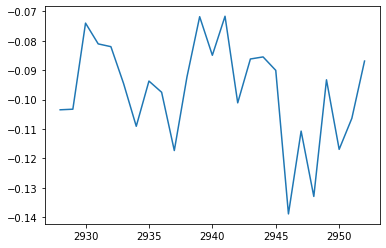

In [34]:
plt.plot(acc[:25])

In [21]:
f,t,Zxx = stft(acc.values, fs=100, nperseg=25, noverlap=0)

In [22]:
ccc = abs(Zxx)
ccc.shape

(13, 1089)

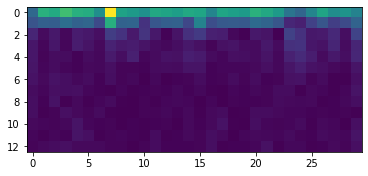

In [23]:
plt.imshow(abs(Zxx)[:,:30])

In [24]:
x = ccc.T
input = []
for i in range(0,len(x),15):
    if i+20 <= len(x):
        input.append(x[i:i+20])
    else:
        break
input = np.array(input)
print(input.shape)

(72, 20, 13)


### 1.5 filtering targeted activities and making the labels sequencials

In [18]:
df = df[df['activity'].isin([1,2,3,4,5,6,7,12,13,16,17])]
df['activity'].loc[(df['activity']==12)] = 8
df['activity'].loc[(df['activity']==13)] = 9
df['activity'].loc[(df['activity']==16)] = 10
df['activity'].loc[(df['activity']==17)] = 0
df[df['activity'] == 10].shape

(0, 5)

In [19]:
df0 =  df[df['activity']==0]
df0_100 = df0.reset_index().iloc[:1000]

df1 =  df[df['activity']==1]
df1_100 = df1.reset_index().iloc[:1000]

df2 =  df[df['activity']==2]
df2_100 = df2.reset_index().iloc[:1000]

df3 =  df[df['activity']==3]
df3_100 = df3.reset_index().iloc[:1000]

df4 =  df[df['activity']==4]
df4_100 = df4.reset_index().iloc[:1000]

df5 =  df[df['activity']==5]
df5_100 = df5.reset_index().iloc[:1000]

df6 =  df[df['activity']==6]
df6_100 = df6.reset_index().iloc[:1000]

df7 =  df[df['activity']==7]
df7_100 = df7.reset_index().iloc[:1000]

In [20]:
df = pd.concat([df0_100, df1_100, df2_100, df3_100,df4_100,df5_100,df6_100,df7_100])

In [21]:
loader_df = pd.DataFrame(columns=['id', 'input_5_timesteps', 'label'])
id = 0
for user in unique_users:
    for action in unique_actions:
        ua_df = df[(df['user']==user) & (df['activity']==action)]
        for t in range(0, ua_df.shape[0], 5):
          vec_acc = ua_df.iloc[t:t+5]['acc_spec'].tolist()
          vec_gyro = ua_df.iloc[t:t+5]['gyro_spec'].tolist()
          vec_acc_gyro = [vec_acc] + [vec_gyro]
          instance = pd.DataFrame({'id': id, 'input_5_timesteps': [vec_acc_gyro], 'label': action})
          loader_df = loader_df.append(instance, ignore_index=True)
          id += 1

In [22]:
x = loader_df['input_5_timesteps']
id = []
label = []
tensor_input = []

for i in range(len(x)):
  try:
    x_tensor = torch.FloatTensor(x[i])
    # print(x_tensor.shape)
    if x_tensor.shape == torch.Size([2, 5, 13, 10]):
      tensor_input.append(x_tensor)
      label.append(loader_df['label'][i])
      id.append(loader_df['id'][i])

  except:
    print('*********',i)

********* 36


/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_54772/607291761.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1639180852547/work/torch/csrc/utils/tensor_new.cpp:201.)
  x_tensor = torch.FloatTensor(x[i])


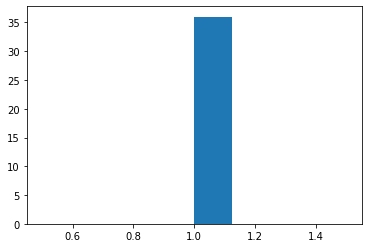

In [23]:
plt.hist(label, bins=8);

In [24]:
len(id), len(label), len(tensor_input)

(36, 36, 36)

In [25]:
np.unique(label, return_counts=True)

(array([1]), array([36]))

### Dataloader

In [33]:
tensor_input = torch.tensor(input)
tensor_input = tensor_input.unsqueeze(1)
tensor_input.shape

torch.Size([72, 1, 20, 13])

In [ ]:
label = np.zeros((72,6))
label[0:72,0] = 1
label

In [31]:
# id = torch.tensor(id)
label = torch.tensor(label)
# tensor_input = torch.stack((tensor_input,tensor_input),dim=1)

/var/folders/5x/3g67fwns0mb68s__c_3fk4wr0000gn/T/ipykernel_3434/855225357.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(label)


In [34]:
tensor_input.shape # (num_of_instances, K:2, t:5, feature: 13,10)

torch.Size([72, 1, 20, 13])

In [35]:
dataset = TensorDataset(tensor_input, label)
train_size = int(0.80 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f'{train_size} training samples')
print(f'{val_size} validation samples')

57 training samples
15 validation samples


In [36]:
torch.manual_seed(0)
batch_size = 5
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
            )
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
            )

In [37]:
for data in train_dataloader:
    inputs, labels = data
    print(inputs.shape)
    print(labels.shape)
    break

torch.Size([5, 1, 20, 13])
torch.Size([5, 6])


In [ ]:
fig, axes = plt.subplots(2, 5, sharex=True, sharey=False, figsize=(15,5))
instance = next(iter(train_dataloader))
for i in range(5):
    axes[0,i].imshow(instance[1][0][0][i])
    axes[0,i].set_title(f'acc timestep {i+1}')
for i in range(5):
    axes[1,i].imshow(instance[1][0][1][i])
    axes[1,i].set_title(f'gyro timestep {i+1}')

## 2. Model

In [ ]:
"""
data.shape: [B, K, T, F]
====== train CNN for every mode ======
conv_in.shape: [B, C, T, F]
conv_out.shape:[B, T, D] D=C*F
============ merge modes =============
attn1_in.shape: [B, T, M, D] M:mode
attn1_out.shape:[B, T, D]
============ train GRU ===============
gru_in.shape: [B, T, D]
gru_out.shape:[B, T, D']
=========== merge time info ==========
attn2_in.shape: [B, T, D']
attn2_out.shape:[B, D']
fc_in.shape: [B, N] N: num_activities
output.shape:[B, N]

"""

### 2.1 CNN

In [39]:
class Conv(nn.Module):
    # input shape: Batch,in_channels,H(time),W(frequency)
    # in this case: Batch, in_channels, time_window, frequency
    def __init__(self, in_channels=1, CONV_C=CONV_C, CONV_K=CONV_K, padding='valid'):
        super(Conv, self).__init__()
        if padding == 'valid':
            self.padding = 0
        elif padding == 'same':
            self.padding = 'same'
        else:
            raise ValueError("Invalid padding mode. Use 'valid' or 'same'.")
            
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, CONV_C[0], [1,CONV_K[0]], stride=(1, 2), padding=self.padding),
            nn.BatchNorm2d(CONV_C[0]), 
            # Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=1-CONV_KEEP_PROB),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(CONV_C[0], CONV_C[1], [1,CONV_K[1]], stride=(1,1), padding=self.padding),
            nn.BatchNorm2d(CONV_C[1]),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=1-CONV_KEEP_PROB),
            nn.MaxPool2d((1,3),stride=1, padding = (0,1))
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(CONV_C[1], CONV_C[2], [1,CONV_K[2]], stride=(1,1), padding=self.padding),
            nn.BatchNorm2d(CONV_C[2]),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((1,3),stride=1, padding =(0,1))
        )
        # self.fc = nn.Linear(in_channels, CONV_C)

    def forward(self, inputs):
        print('x.shape 1: ', inputs.shape)
        x = self.conv1(inputs)
        print('x.shape 2: ', x.shape)
        x = self.conv2(x)
        print('x.shape 3: ', x.shape)
        x = self.conv3(x)
        print('x.shape 4: ', x.shape) #[B,C,T,f]
        xx = x.transpose(1,2).contiguous() #[B,T,C,f]

        xx = xx.unsqueeze(2) # shape = [B,T,1,C,f]
        print('x.shape 5: ', xx.shape)
        # x = torch.flatten(x, start_dim=1) # shape = [B,C*f*t]
        # print('x.shape 5: ', x.shape)
        # x = self.fc(x)
        # print('x.shape 6: ', x.shape)
        return xx

### 2.2 Attention

In [53]:
class ATTEN_M(nn.Module):
    def __init__(self):
        super(ATTEN_M, self).__init__()
        self.d = 128
        self.w = torch.nn.Parameter(torch.randn(self.d, requires_grad=True) * 0.1) # weights
        self.b = torch.nn.Parameter(torch.randn(1, requires_grad=True))

    def forward(self, inputs):
        activation = torch.tanh(torch.tensordot(inputs, self.w, dims=[[-1],[0]]) + self.b)  # b * t * m
        print('activation:',activation.shape)
        alphas = F.softmax(activation, dim=2)  # b * t * m
        print("alphas:", str(alphas.shape))
        
        beta = inputs * alphas.unsqueeze(-1)
        print('beta:',beta.shape)
        output = torch.sum(beta, dim=2)  # b * t * d = [b,t,i,d] * [b,t,i,1] element_wise
        print('attn_m.shape:',output.shape) #shape: [batch, time_window, feature_dim]
        return output, alphas

In [41]:
def attention_mode(inputs): # Attention-fusion Subnet
    """
    input shape: [batch, time_window, input_mode, feature_dim(f*channels)]
    output shape:[batch, time_window, feature_dim]
    
    """
    d = inputs.shape[-1]

    w = torch.nn.Parameter(torch.randn(d, requires_grad=True) * 0.1) # weights
    b = torch.nn.Parameter(torch.randn(1, requires_grad=True))

    activation = torch.tanh(torch.tensordot(inputs, w, dims=1) + b)  # b * t * m
    alphas = F.softmax(activation, dim=2)  # b * t * m
    print("alphas ", str(alphas.shape))

    # l = inputs.shape[-2]
    # print(d,l)
    # w = torch.randn([d,l], requires_grad=True, dtype=torch.double) * 0.1 # weights
    # b = torch.randn(l, requires_grad=True, dtype=torch.double) * 0.1 
    # omega = torch.randn(l, requires_grad=True, dtype=torch.double) * 0.1 
    # activation = torch.tanh(torch.matmul(inputs,w) + b)  # b * t * m * m = [b,t,i,d] * [d,i]
    # activation = torch.matmul(activation,omega) # b * t * m = [b,t,i,i] * [i]
    # alphas = F.softmax(activation, dim=2)  # b * t * m
    # print("alphas ", str(alphas.shape))
    
    beta = inputs * alphas.unsqueeze(-1)
    print(beta.shape)
    output = torch.sum(beta, dim=2)  # b * t * d = [b,t,i,d] * [b,t,i,1] element_wise
    print(output.shape) #shape: [batch, time_window, feature_dim]
    return output, alphas

In [57]:
class ATTEN_T(nn.Module):
    def __init__(self, d = GRU_H[-1], attention_size=AT):
        super(ATTEN_T, self).__init__()
        self.d = d
        self.w_omega = nn.Parameter(torch.randn(self.d, attention_size) * 0.1)
        self.b_omega = nn.Parameter(torch.randn(attention_size) * 0.1)
        self.u_omega = nn.Parameter(torch.randn(attention_size) * 0.1)

    def forward(self, inputs):
        v = torch.tanh(torch.matmul(inputs, self.w_omega) + self.b_omega)  # (B,T,A) shape
        # For each of the timestamps, its vector of size A from `v` is reduced with the `u` vector
        vu = torch.matmul(v, self.u_omega).squeeze(-1)  # (B,T) shape
        alphas = F.softmax(vu, dim=1)   # (B,T) shape

        # Output of (Bi-)RNN is reduced with the attention vector; the result has (B,D) shape
        output = torch.sum(inputs * alphas.unsqueeze(-1), dim=1)

        return output, alphas

In [117]:
def attention_time(inputs, attention_size):
    """
    input shape: [batch, time_window, feature_dim]
    output shape:[batch, feature_dim]
    """
    if isinstance(inputs, tuple):
        # In case of Bi-RNN, concatenate the forward and the backward RNN outputs.
        inputs = torch.cat(inputs, 2)
    
    hidden_size = inputs.shape[2]  #inputs: (B,T,D)

    # Trainable parameters
    w_omega = nn.Parameter(torch.randn(hidden_size, attention_size) * 0.1)
    b_omega = nn.Parameter(torch.randn(attention_size) * 0.1)
    u_omega = nn.Parameter(torch.randn(attention_size) * 0.1)
    # with torch.name_scope('v'):
    #     # Applying fully connected layer with non-linear activation to each of the B*T timestamps;
    #     # the shape of `v` is (B,T,D)*(D,A)=(B,T,A), where A=attention_size
    #     v = torch.tanh(torch.matmul(inputs, w_omega) + b_omega)

    v = torch.tanh(torch.matmul(inputs, w_omega) + b_omega)  # (B,T,A) shape
    # For each of the timestamps, its vector of size A from `v` is reduced with the `u` vector
    vu = torch.matmul(v, u_omega).squeeze(-1)  # (B,T) shape
    alphas = F.softmax(vu, dim=1)   # (B,T) shape

    # Output of (Bi-)RNN is reduced with the attention vector; the result has (B,D) shape
    output = torch.sum(inputs * alphas.unsqueeze(-1), dim=1)

    return output, alphas


### 2.3 AttnSense

In [81]:
class AttnSense(nn.Module):
    def __init__(self):
        super(AttnSense, self).__init__()
        self.conv = Conv()
        # self.attn1 = attention_mode()
        # self.attn2 = attention_time()
        self.attn1 = ATTEN_M()
        self.attn2 = ATTEN_T()

        # Define GRU layer
        # nn.GRU(input_size, hidden_size, num_layers)
        # input:[batch, seq_len, input_size], h_0:[num_layers * num_directions, batch, hidden_size], defaults to zeros if not provided.
        # output: [batch, seq_len, hidden_size * num_directions], containing the output features (h_t) from the last layer of the GRU, for each t.
        # h_n:[num_layers * num_directions, batch, hidden_size], containing the final hidden state for the input sequence.
        self.g_input_size = CONV_C[2]*2
        self.gru1 = nn.GRU(self.g_input_size, GRU_H[0], batch_first=True)
        self.gru2 = nn.GRU(GRU_H[0], GRU_H[1], batch_first=True)
        self.fc_gru = nn.Linear(GRU_H[1],6) # input: [B,D]

    def forward(self, inputs, modes):
        # split data based on modality and train Conv for every modality.
        # m = []
        # for i in range(modes):
        #     m.append(inputs[0][i].reshape(BATCH_SIZE,1,WIDE,13))

        # conv_out_1 = self.conv(m[0])
        # conv_out_2 = self.conv(m[1])
        # conv_out_all = torch.cat([conv_out_1, conv_out_2], dim=2) # [B,T,M,C,f]
        conv_out_1 = self.conv(inputs)
        conv_out_2 = self.conv(inputs)
        conv_out_all = torch.cat([conv_out_1, conv_out_2], dim=2) # [B,T,M,C,f]
        print('conv_out_all.shape:',conv_out_all.shape)
        # print('conv_out.shape:', conv_out_1.shape, conv_out_2.shape, conv_out_all.shape)

        attn1_in = conv_out_all.view(conv_out_all.size(0), conv_out_all.size(1), conv_out_all.size(2),
                                            conv_out_all.size(3) * conv_out_all.size(4))
        print('attn1_in.shape:', attn1_in.shape) #[B,T,M,D]
        attn1_out, _ = self.attn1(attn1_in) # out: [B,T,D]

        # self.init_state = torch.zeros(2, attn1_out.size(0), self.cell.hidden_size, dtype=torch.float32)
        # h_t = self.init_state
        # for t in range(attn1_out.size(1)):
        #     h_t = self.cell(attn1_out[:, t], h_t)
        #     gru_out.append(h_t)
        # gru_out = torch.stack(gru_out, dim=1)  # (batch, time_window, DIM)

        gru_1, _ = self.gru1(attn1_out)
        gru_out, _ = self.gru2(gru_1)
        print('gru_out.shape:', gru_out.shape) # [B,T,D']

        # attn2_out, _ = self.attn2(gru_out, attention_size=AT) 
        attn2_out, _ = self.attn2(gru_out) 
        print('attn2_out.shape:', attn2_out.shape) # [B,D']
        
        x = self.fc_gru(attn2_out)
        x = F.softmax(x, dim=1)
        print(x,x.shape)

        return x


## 3. Experiment

### 3.1 parameters

### 3.2 data loader

In [ ]:
torch.manual_seed(0)
train_loader = DataLoader(
    train_dataset,  
    sampler = RandomSampler(train_dataset), 
    batch_size = BATCH_SIZE
)
val_loader = DataLoader(
    val_dataset, 
    sampler = SequentialSampler(val_dataset),
    batch_size = BATCH_SIZE
)
test_loader = DataLoader(
    test_dataset,
    sampler = SequentialSampler(test_dataset),
    batch_size = BATCH_SIZE
)

### 3.3 training

In [82]:
def train_model(model, traindata, valdata, epochs, path, num, lr=0.001):
    model = model.to(device).float()
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.RMSprop(model.parameters(), lr)#.to(device)

    # low_loss = 0
    history = dict(train=[], val=[])
    t_s = time.time()

    for epoch in range(1,epochs+1):
        t_ss = time.time()
        model = model.train()
        train_losses = []
        val_losses = []
        print(epoch, "start!")
        for data in traindata:
            inputs, labels = data
            inputs = inputs.to(device).float()
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs,modes=None)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        history['train'].append(train_loss)
        
        if epoch % 50 == 49:
            model = model.eval()
            with torch.no_grad():
                for data in valdata:
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    outputs = model(inputs,modes=None)
                    loss = criterion(outputs, labels)
                    val_losses.append(loss.item())

            val_loss = np.mean(val_losses)
            history['val'].append(val_loss)
            print(f'Epoch = {epoch}, val loss = {val_loss}')

        t_ee = time.time()
        print(f'Epoch = {epoch}, train loss = {train_loss}, time = {t_ee-t_ss}')

        # if val_loss < 1.7 and low_loss == 0:
        #     low_loss = val_loss
        #     torch.save(model.state_dict(), path+'Attn_model'+num)
        # if val_loss < low_loss:
        #     low_loss = val_loss
        #     torch.save(model.state_dict(), path+'Attn_model'+num)

    t_e = time.time()
    print(f'Finish! time_cost: {t_e-t_s}')

    return model.eval(), history

In [83]:
model = AttnSense()
# model, history = train_model(model, train_loader, val_loader, EPOCH,path,num=1)
model, history = train_model(model, train_dataloader, train_dataloader, 2, PATH,num=1,lr=0.0001)

1 start!
x.shape 1:  torch.Size([5, 1, 20, 13])
x.shape 2:  torch.Size([5, 32, 20, 6])
x.shape 3:  torch.Size([5, 32, 20, 4])
x.shape 4:  torch.Size([5, 64, 20, 2])
x.shape 5:  torch.Size([5, 20, 1, 64, 2])
x.shape 1:  torch.Size([5, 1, 20, 13])
x.shape 2:  torch.Size([5, 32, 20, 6])
x.shape 3:  torch.Size([5, 32, 20, 4])
x.shape 4:  torch.Size([5, 64, 20, 2])
x.shape 5:  torch.Size([5, 20, 1, 64, 2])
conv_out_all.shape: torch.Size([5, 20, 2, 64, 2])
attn1_in.shape: torch.Size([5, 20, 2, 128])
activation: torch.Size([5, 20, 2])
alphas: torch.Size([5, 20, 2])
beta: torch.Size([5, 20, 2, 128])
attn_m.shape: torch.Size([5, 20, 128])
gru_out.shape: torch.Size([5, 20, 120])
attn2_out.shape: torch.Size([5, 120])
tensor([[0.1989, 0.1782, 0.1426, 0.1706, 0.1416, 0.1682],
        [0.1702, 0.1973, 0.1612, 0.1737, 0.1466, 0.1511],
        [0.1874, 0.1895, 0.1569, 0.1762, 0.1299, 0.1601],
        [0.1945, 0.1780, 0.1511, 0.1874, 0.1424, 0.1466],
        [0.1715, 0.1859, 0.1581, 0.1858, 0.1486, 0.1

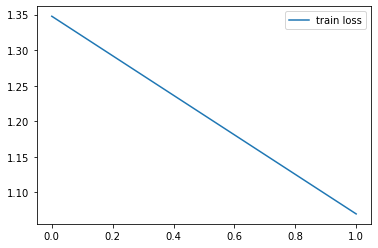

In [84]:
plt.plot(history['train'],label='train loss')
# plt.plot(history['val'], label='val loss')
plt.legend()

In [66]:
""" save model """
model_1 = model
MODEL_PATH = 'Attn_model_final.pth'
torch.save(model_1, MODEL_PATH)

In [67]:
model_2 = torch.load("Attn_model_final.pth")
print(model_2.forward)

<bound method AttnSense.forward of AttnSense(
  (conv): Conv(
    (conv1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(1, 3), stride=(1, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.19999999999999996, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(1, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.19999999999999996, inplace=False)
      (4): MaxPool2d(kernel_size=(1, 3), stride=1, padding=(0, 1), dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 3), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=(1, 3), stride=1, padding=(0, 1), dilation=1, ceil_mode=Fal

### 3.4 evaluation

In [93]:
def evaluation_model(model, testdata):
    model = model.eval().float()
    correct = 0
    total = 0
    all_preds = torch.tensor([])
    all_lab = torch.tensor([])

    with torch.no_grad():
        for data in testdata:
            inputs, labels = data
            outputs = model(inputs.float(), modes=None) # [B, n_classes]

            true = torch.argmax(labels, 1) # [B]
            predict = torch.argmax(outputs.data, 1) # [B]
            total += labels.size(0)
            correct += (predict == true).sum().item()

            all_preds = torch.cat((all_preds, predict) ,dim=0)
            all_lab = torch.cat((all_lab, true) ,dim=0)
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
    print('all_preds.shape: ', all_preds.shape, 'all_labels.shape: ', all_lab.shape)
    return all_lab, all_preds

In [94]:
y_true, y_pred = evaluation_model(model, validation_dataloader)

x.shape 1:  torch.Size([5, 1, 20, 13])
x.shape 2:  torch.Size([5, 32, 20, 6])
x.shape 3:  torch.Size([5, 32, 20, 4])
x.shape 4:  torch.Size([5, 64, 20, 2])
x.shape 5:  torch.Size([5, 20, 1, 64, 2])
x.shape 1:  torch.Size([5, 1, 20, 13])
x.shape 2:  torch.Size([5, 32, 20, 6])
x.shape 3:  torch.Size([5, 32, 20, 4])
x.shape 4:  torch.Size([5, 64, 20, 2])
x.shape 5:  torch.Size([5, 20, 1, 64, 2])
conv_out_all.shape: torch.Size([5, 20, 2, 64, 2])
attn1_in.shape: torch.Size([5, 20, 2, 128])
activation: torch.Size([5, 20, 2])
alphas: torch.Size([5, 20, 2])
beta: torch.Size([5, 20, 2, 128])
attn_m.shape: torch.Size([5, 20, 128])
gru_out.shape: torch.Size([5, 20, 120])
attn2_out.shape: torch.Size([5, 120])
tensor([[0.9712, 0.0057, 0.0078, 0.0044, 0.0047, 0.0062],
        [0.9719, 0.0056, 0.0076, 0.0043, 0.0046, 0.0060],
        [0.9711, 0.0057, 0.0078, 0.0044, 0.0047, 0.0062],
        [0.9710, 0.0057, 0.0078, 0.0044, 0.0047, 0.0062],
        [0.9714, 0.0057, 0.0077, 0.0044, 0.0047, 0.0062]]) to

In [95]:
confusion_matrix(y_true, y_pred, labels=activities)

array([[15]])

<AxesSubplot:>

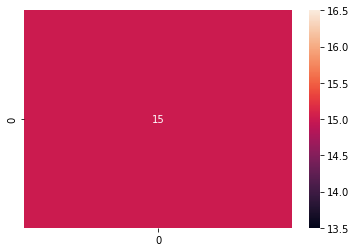

In [96]:
sns.heatmap(pd.DataFrame(confusion_matrix(y_true, y_pred), columns=activities, index=activities), annot=True)